#### A notebook that implements techniques from the paper 
#### "Towards Deep Learning Models Resistant to Adversarial Attacks"

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import util


In [2]:
# Download data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Example image:


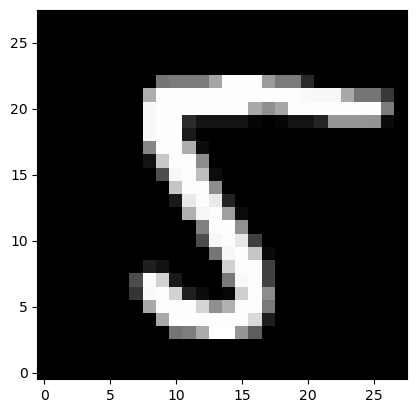

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
print("Example image:")
util.imgshow(X[1,0,:,:])

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Basic ConvNet (Non-robust)

In [5]:
OUT_C1 = 8
OUT_C2 = 16
DENSE_UNITS = 256

class BasicConvNet(nn.Module):
    def __init__(self, out_c1, out_c2, dense_units, n_classes=10):
        super(BasicConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_c1, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=out_c1, out_channels=out_c2, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, dense_units)
        self.logits = nn.Linear(dense_units,n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        out = self.logits(F.relu(self.fc1(x)))
        return out


basic_conv_model = BasicConvNet(OUT_C1, OUT_C2, DENSE_UNITS)

In [ ]:
# Train basic model
optimizer = torch.optim.SGD(basic_conv_model.parameters(), lr=1e-2, momentum=0.9)

conv_loss, conv_acc = util.train(basic_conv_model, train_dataloader, test_dataloader, optimizer)

In [10]:
# Evaluate basic model
util.test(basic_conv_model, nn.CrossEntropyLoss(), test_dataloader)

# Save basic model to disk
torch.save(basic_conv_model, "basic_conv_model.pt")

[TEST] Mean loss 0.0385 | Accuracy 0.9899


In [8]:
# Run this cell to load the model from disk

basic_conv_model = torch.load("basic_conv_model.pt")

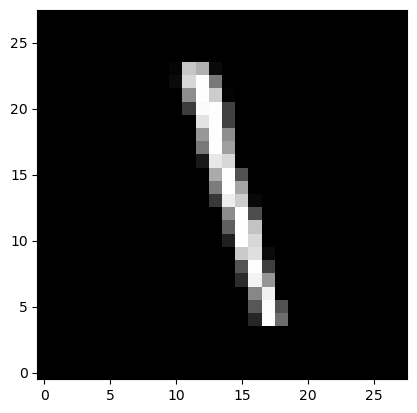

Predicted class probabilities:
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


In [9]:
# Test the model against adversarial examples

# Take sample image
base_image = Variable(X[2][0], requires_grad=True)
util.imgshow(base_image)
logits = basic_conv_model(base_image[None, None, :])
print("Predicted class probabilities:")
print([f"{e.item():.2f}" for e in torch.softmax(logits, axis=1)[0]])


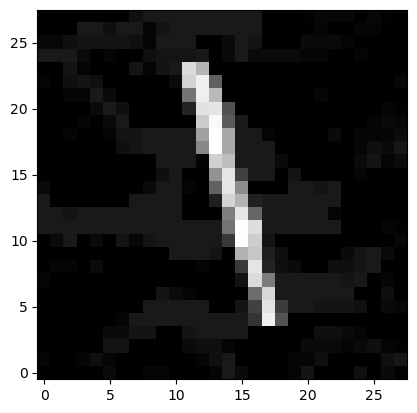

Predicted class probabilities:
['0.00', '0.35', '0.00', '0.00', '0.00', '0.00', '0.00', '0.64', '0.00', '0.00']


In [10]:
# Perturb image
epsilon = 0.1
labels = torch.tensor([1]) # True label is 1
criterion = nn.CrossEntropyLoss()
adv_image = util.get_adversarial_examples(basic_conv_model, base_image[None, None, :], labels, criterion, epsilon)
util.imgshow(adv_image[0,0,:,:])

# Evaluate model on adversarial example
logits = basic_conv_model(adv_image)
print("Predicted class probabilities:")
print([f"{e.item():.2f}" for e in torch.softmax(logits, axis=1)[0]])

#### Saddle point ConvNet (Robust)

In [ ]:
# Train adversarial model
adv_conv_model = BasicConvNet(OUT_C1, OUT_C2, DENSE_UNITS)

optimizer = torch.optim.SGD(adv_conv_model.parameters(), lr=1e-2, momentum=0.9)

conv_loss, conv_acc = util.train_adversarial(adv_conv_model, train_dataloader, test_dataloader, optimizer)

In [13]:
# Evaluate adversarial model
util.test(adv_conv_model, nn.CrossEntropyLoss(), test_dataloader)

# Save adversarial model to disk
torch.save(adv_conv_model, "adv_conv_model.pt")

[TEST] Mean loss 0.3995 | Accuracy 0.8828


In [16]:
# Run this cell to load the model from disk

adv_conv_model = torch.load("adv_conv_model.pt")

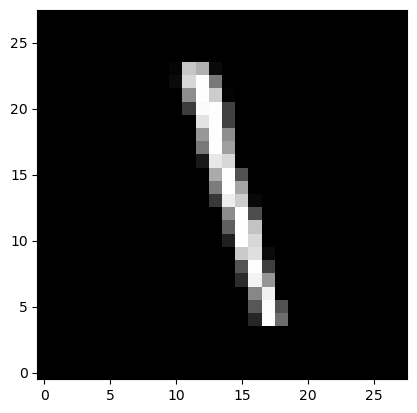

Predicted class probabilities:
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


In [17]:
# Test the model against adversarial examples

# Take sample image
base_image = Variable(X[2][0], requires_grad=True)
util.imgshow(base_image)
logits = adv_conv_model(base_image[None, None, :])
print("Predicted class probabilities:")
print([f"{e.item():.2f}" for e in torch.softmax(logits, axis=1)[0]])


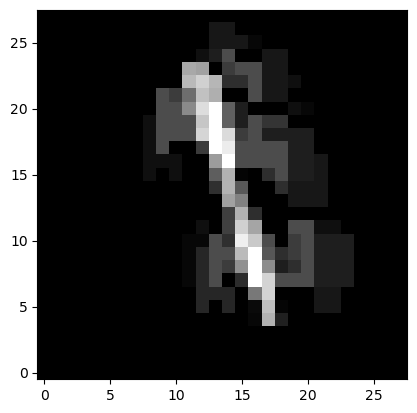

Predicted class probabilities:
['0.05', '0.33', '0.05', '0.07', '0.10', '0.08', '0.05', '0.09', '0.10', '0.08']


In [23]:
# Perturb image
epsilon = 0.3
labels = torch.tensor([1]) # True label is 1
criterion = nn.CrossEntropyLoss()
adv_image = util.get_adversarial_examples(adv_conv_model, base_image[None, None, :], labels, criterion, epsilon)
util.imgshow(adv_image[0,0,:,:])

# Evaluate model on adversarial example
logits = adv_conv_model(adv_image)
print("Predicted class probabilities:")
print([f"{e.item():.2f}" for e in torch.softmax(logits, axis=1)[0]])